In [1]:
# numpy
import numpy as np
# classifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import os
from random import shuffle
import pandas as pd
from sklearn import model_selection, preprocessing, naive_bayes
import string
from sklearn.externals import joblib
from sklearn.decomposition import LatentDirichletAllocation
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from utilities import read_fileNames, readFilesFromSources

c:\users\lahiru ransara\appdata\local\programs\python\python37\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
#create source
sources = []

datapath = './Real_Life_Trial_Data/'

In [3]:
#read file names from datapath
read_fileNames(sources, datapath,'Deceptive')
deceptiveCount=len(sources)
read_fileNames(sources, datapath,'Truthful')
truthCount=len(sources)-deceptiveCount

In [4]:
#read text files from source list
text = []
readFilesFromSources(text,sources)

In [5]:
#create label array corresponding to text files
labels=np.empty(len(sources))
np.concatenate((np.ones(deceptiveCount, dtype=int),np.zeros(truthCount, dtype=int)),out=labels)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

In [6]:
# create a dataframe using texts and lables
trainDF = pd.DataFrame()
trainDF['text'] = text
trainDF['label'] = labels

In [7]:
len(set(trainDF['label'].values))

2

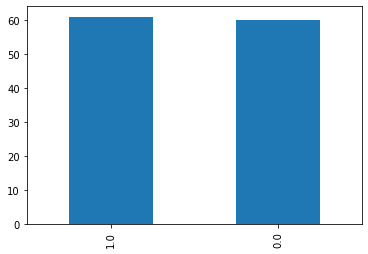

In [8]:
trainDF['label'].value_counts().plot(kind='bar')

In [9]:
def _reciprocal_rank(true_labels: list, machine_preds: list):
    """Compute the reciprocal rank at cutoff k"""
    
    # add index to list only if machine predicted label exists in true labels
    tp_pos_list = [(idx + 1) for idx, r in enumerate(machine_preds) if r in true_labels]

    rr = 0
    if len(tp_pos_list) > 0:
        # for RR we need position of first correct item
        first_pos_list = tp_pos_list[0]
        
        # rr = 1/rank
        rr = 1 / float(first_pos_list)

    return rr

def compute_mrr_at_k(items:list):
    """Compute the MRR (average RR) at cutoff k"""
    rr_total = 0
    
    for item in items:   
        rr_at_k = _reciprocal_rank(item[0],item[1])
        rr_total = rr_total + rr_at_k
        mrr = rr_total / 1/float(len(items))

    return mrr

def collect_preds(Y_test,Y_preds):
    """Collect all predictions and ground truth"""
    
    pred_gold_list=[[[Y_test[idx]],pred] for idx,pred in enumerate(Y_preds)]
    return pred_gold_list
             
def compute_accuracy(eval_items:list):
    correct=0
    total=0
    
    for item in eval_items:
        true_pred=item[0]
        machine_pred=set(item[1])
        
        for cat in true_pred:
            if cat in machine_pred:
                correct+=1
                break
    
    
    accuracy=correct/float(len(eval_items))
    return accuracy

In [10]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

import numpy as np
import logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

def extract_features(df,field,training_data,testing_data,type="binary"):
    """Extract features using different methods"""
    
    logging.info("Extracting features and creating vocabulary...")
    
    if "binary" in type:
        
        # BINARY FEATURE REPRESENTATION
        cv= CountVectorizer(binary=True, max_df=0.95)
        cv.fit_transform(training_data[field].values)
        
        train_feature_set=cv.transform(training_data[field].values)
        test_feature_set=cv.transform(testing_data[field].values)
        
        return train_feature_set,test_feature_set,cv
  
    elif "counts" in type:
        
        # COUNT BASED FEATURE REPRESENTATION
        cv= CountVectorizer(binary=False, max_df=0.95)
        cv.fit_transform(training_data[field].values)
        
        train_feature_set=cv.transform(training_data[field].values)
        test_feature_set=cv.transform(testing_data[field].values)
        
        return train_feature_set,test_feature_set,cv
    
    else:    
        
        # TF-IDF BASED FEATURE REPRESENTATION
        tfidf_vectorizer=TfidfVectorizer(use_idf=True, max_df=0.95)
        tfidf_vectorizer.fit_transform(training_data[field].values)
        
        train_feature_set=tfidf_vectorizer.transform(training_data[field].values)
        test_feature_set=tfidf_vectorizer.transform(testing_data[field].values)
        
        return train_feature_set,test_feature_set,tfidf_vectorizer

In [11]:
def get_top_k_predictions(model,X_test,k):
    
    # get probabilities instead of predicted labels, since we want to collect top 3
    probs = model.predict_proba(X_test)

    # GET TOP K PREDICTIONS BY PROB - note these are just index
    best_n = np.argsort(probs, axis=1)[:,-k:]
    
    # GET CATEGORY OF PREDICTIONS
    preds=[[model.classes_[predicted_cat] for predicted_cat in prediction] for prediction in best_n]
    
    preds=[ item[::-1] for item in preds]
    
    return preds

In [12]:
def train_model(df,field="text",feature_rep="binary",top_k=3):
    
    logging.info("Starting model training...")
    
    # GET A TRAIN TEST SPLIT (set seed for consistent results)
    training_data, testing_data = train_test_split(df,test_size=0.1, random_state = 2000)

    # GET LABELS
    Y_train=training_data['label'].values
    Y_test=testing_data['label'].values
     
    # GET FEATURES
    X_train,X_test,feature_transformer=extract_features(df,field,training_data,testing_data,type=feature_rep)

    # INIT LOGISTIC REGRESSION CLASSIFIER
    logging.info("Training a Logistic Regression Model...")
    scikit_log_reg = LogisticRegression(verbose=1, solver='liblinear',random_state=0, C=5, penalty='l2',max_iter=1000)
    model=scikit_log_reg.fit(X_train,Y_train)

    # GET TOP K PREDICTIONS
    preds=get_top_k_predictions(model,X_test,top_k)
    print(preds)
    print(Y_test)
    
    # GET PREDICTED VALUES AND GROUND TRUTH INTO A LIST OF LISTS - for ease of evaluation
    eval_items=collect_preds(Y_test,preds)
    
    # GET EVALUATION NUMBERS ON TEST SET -- HOW DID WE DO?
    logging.info("Starting evaluation...")
    accuracy=compute_accuracy(eval_items)
    mrr_at_k=compute_mrr_at_k(eval_items)
    
    logging.info("Done training and evaluation.")
    
    return model,feature_transformer,accuracy,mrr_at_k

In [14]:
field='text'
feature_rep='tfidf'
top_k=1

model,transformer,accuracy,mrr_at_k=train_model(trainDF,field=field,feature_rep=feature_rep,top_k=top_k)
print("\nAccuracy={0}; MRR={1}".format(accuracy,mrr_at_k))

2019-12-31 17:09:54,917 : INFO : Starting model training...
2019-12-31 17:09:54,928 : INFO : Extracting features and creating vocabulary...
2019-12-31 17:09:54,982 : INFO : Training a Logistic Regression Model...
2019-12-31 17:09:55,001 : INFO : Starting evaluation...
2019-12-31 17:09:55,005 : INFO : Done training and evaluation.


[LibLinear][[0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0]]
[0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0.]

Accuracy=0.5384615384615384; MRR=0.5384615384615384


In [15]:
# https://www.cnn.com/2019/07/19/politics/george-nader-child-porn-sex-charges/index.html
test_features=transformer.transform(["George Aref Nader, who was a key witness in special counsel Robert Mueller's Russia investigation, faces new charges of transporting a minor with intent to engage in criminal sexual activity and child pornography"])
get_top_k_predictions(model,test_features,1)

[[1.0]]

In [18]:
# 1 = Deceptive & 0 = Truth